# Duplicate detection
Notebook to check the duplicate detection on a small area of the North Sea with different values of the parameters (searching radii).

In [1]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using PyPlot
using Dates
using Statistics
using Random
using Printf
using Compat

In [49]:
# Files that will be tested: 1° by 1° region, salinity measurements
obsfile1 = "NorthSea/output/northsea_obs_01.nc";
obsfile2 = "NorthSea/output/northsea_obs_02.nc";

## Read data
Download if necessary

In [50]:
if !isfile(obsfile1)
    download("https://dox.ulg.ac.be/index.php/s/jX2FnNQUjRnKuri/download", obsfile1)
else
    @info "File already downloaded"
end
if !isfile(obsfile2)
    download("https://dox.ulg.ac.be/index.php/s/dOhPUX5e7eEw5L0/download", obsfile2)
else
    @info "File already downloaded"
end

┌ Info: File already downloaded
└ @ Main In[50]:4
┌ Info: File already downloaded
└ @ Main In[50]:9


In [51]:
varname = "sea_water_salinity"
@time obsval1, obslon1, obslat1, obsdepth1, obstime1, obsid1 = 
DIVAnd.loadobs(Float64, obsfile1, varname);

@time obsval2, obslon2, obslat2, obsdepth2, obstime2, obsid2 = 
DIVAnd.loadobs(Float64, obsfile2, varname);

  2.604358 seconds (6.56 M allocations: 347.217 MiB, 5.05% gc time)
  0.018403 seconds (61.57 k allocations: 10.362 MiB)


In [52]:
ndata1 = length(obslon1);
ndata2 = length(obslon2);
@info("Number of data in dataset 1: $(ndata1)")
@info("Number of data in dataset 2: $(ndata2)")

┌ Info: Number of data in dataset 1: 18159
└ @ Main In[52]:3
┌ Info: Number of data in dataset 2: 30564
└ @ Main In[52]:4


### Data plot

In [53]:
function plot_data_post(obslon1::Array, obslat1::Array, obslon2::Array, obslat2::Array)
    PyPlot.plot(obslon1, obslat1, "ko", markersize=0.03, alpha=.7)
    PyPlot.plot(obslon2, obslat2, "ro", markersize=0.03, alpha=.7)
end

plot_data_post (generic function with 1 method)

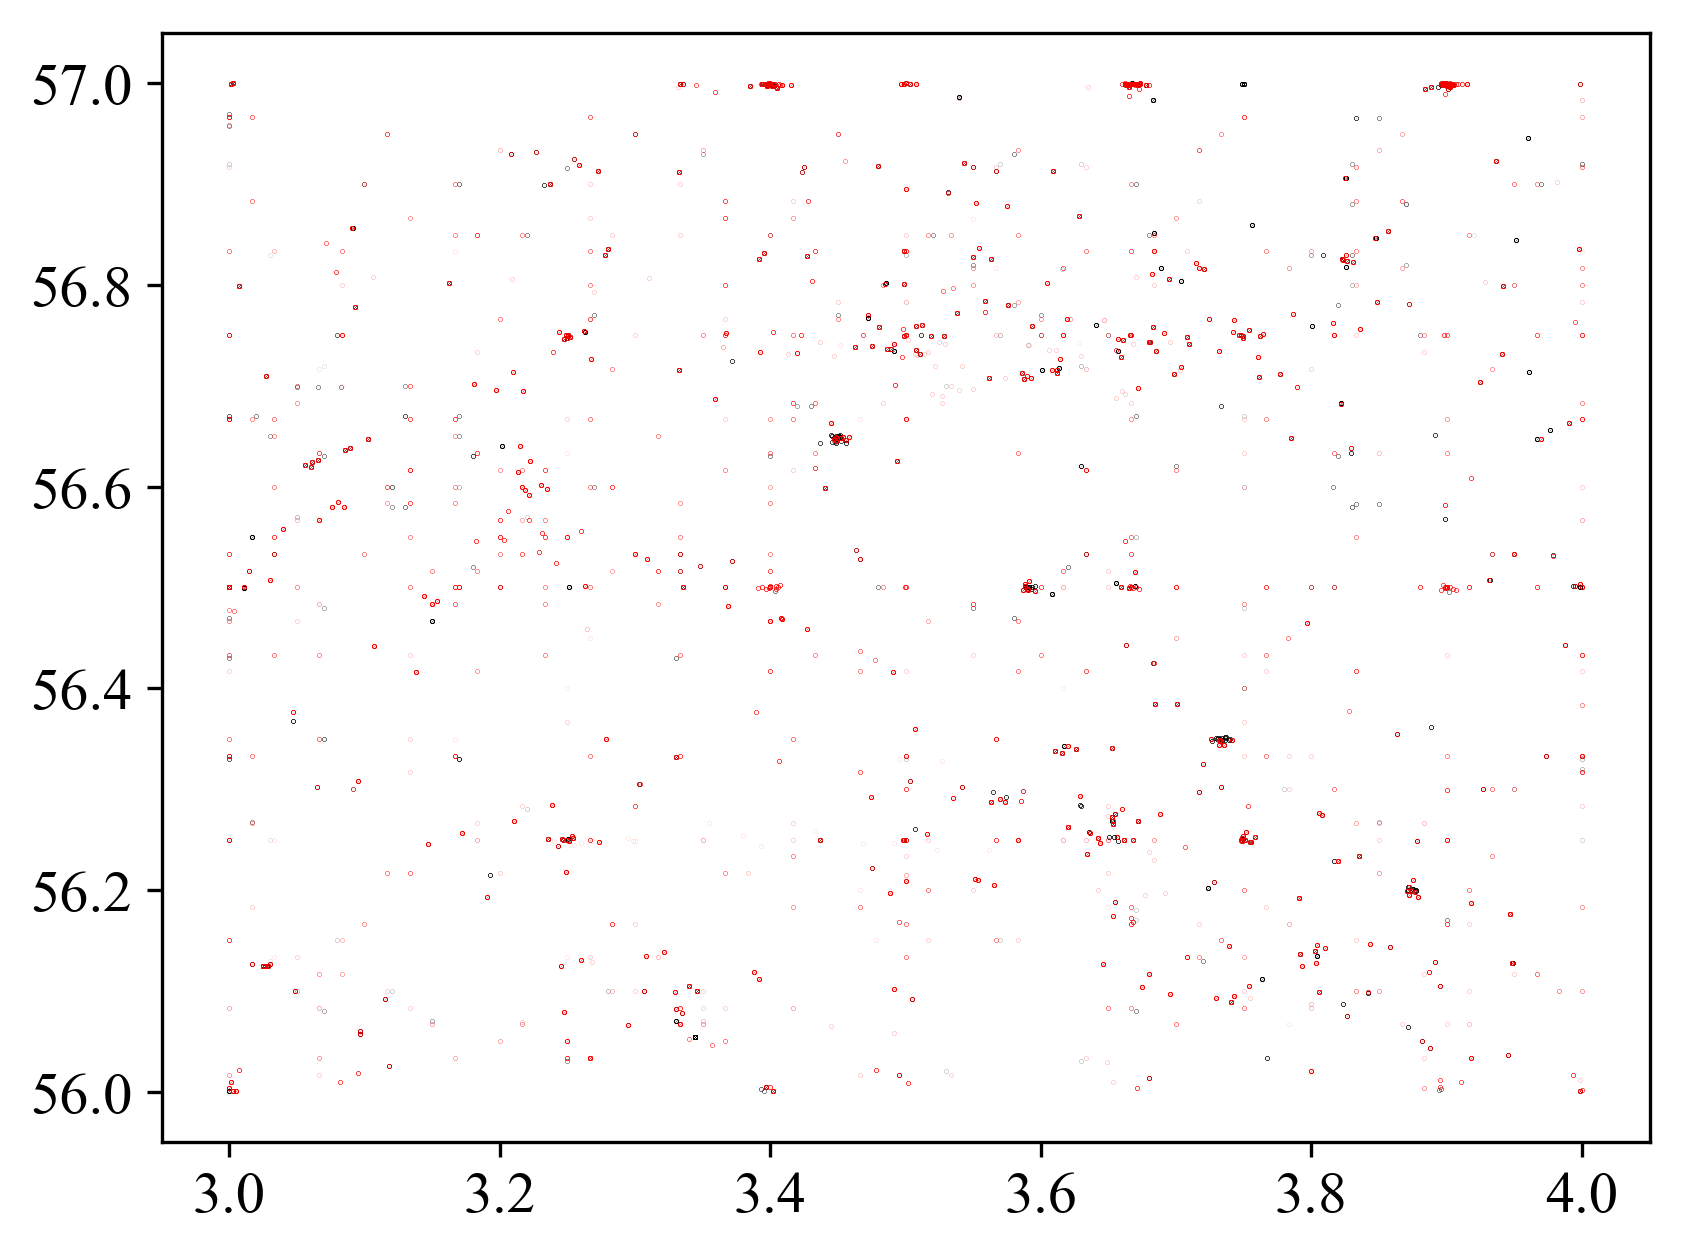

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc18f0c35c0>

In [54]:
plot_data_post(obslon1, obslat1, obslon2, obslat2)

## Duplicate detection
We check for different values of the parameters how many duplicates are found.

In [11]:
Δlon = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0];
Δdepth = [0.005, 0.01, 0.05, 0.1, 0.5, 1., 5.0];

In [12]:
duplicate_percent = Array{Float64}(undef, length(Δlon), length(Δdepth))

for (i, dx) in enumerate(Δlon)
    for (j, dz) in enumerate(Δdepth)
        @time dupl = DIVAnd.Quadtrees.checkduplicates(
            (obslon1,obslat1,obsdepth1,obstime1), obsval1,
            (obslon2,obslat2,obsdepth2,obstime2), obsval2,
            (dx, dx, dz,1/(24.)),0.01);

            index = findall(.!isempty.(dupl));
            ndupl = length(index);
            pcdupl = (ndupl / ndata1) * 100.;
            @debug("Number of possible duplicates: $ndupl")
            @debug("Percentage of duplicates: $pcdupl%")

            duplicate_percent[i, j] = pcdupl;
    end
end

  1.978640 seconds (3.59 M allocations: 199.623 MiB, 3.92% gc time)
  0.521396 seconds (57.61 k allocations: 31.309 MiB, 0.79% gc time)
  0.512576 seconds (97.17 k allocations: 56.664 MiB, 1.96% gc time)
  0.527036 seconds (102.28 k allocations: 59.938 MiB, 1.66% gc time)
  0.536624 seconds (121.56 k allocations: 72.286 MiB, 2.07% gc time)
  0.537708 seconds (126.37 k allocations: 75.479 MiB, 2.07% gc time)
  0.587199 seconds (137.41 k allocations: 84.441 MiB, 2.66% gc time)
  0.523131 seconds (56.66 k allocations: 30.701 MiB, 1.47% gc time)
  0.526065 seconds (61.43 k allocations: 33.760 MiB, 0.63% gc time)
  0.530782 seconds (102.78 k allocations: 60.259 MiB, 1.59% gc time)
  0.526022 seconds (108.04 k allocations: 63.628 MiB, 1.67% gc time)
  0.634285 seconds (129.56 k allocations: 77.065 MiB, 14.80% gc time)
  0.540133 seconds (134.19 k allocations: 80.495 MiB, 2.82% gc time)
  0.611002 seconds (146.33 k allocations: 90.253 MiB, 2.16% gc time)
  0.516635 seconds (57.09 k allocation

Now let's test the effect of the tolerance on the field value.

In [57]:
Δval = [0.001, 0.01, 0.1, 1.0, 10.]
for tol in Δval
    @time dupl = DIVAnd.Quadtrees.checkduplicates(
        (obslon1,obslat1,obsdepth1,obstime1), obsval1,
        (obslon2,obslat2,obsdepth2,obstime2), obsval2,
        (0.05, 0.05, 0.1, 1/(24.)), tol);

        index = findall(.!isempty.(dupl));
        ndupl = length(index);
        pcdupl = (ndupl / ndata1) * 100.;
        @info("Number of possible duplicates: $ndupl")
        @info("Percentage of duplicates: $pcdupl%")

end

  0.579248 seconds (110.28 k allocations: 65.056 MiB, 1.46% gc time)


┌ Info: Number of possible duplicates: 10934
└ @ Main In[57]:11
┌ Info: Percentage of duplicates: 60.21256677129798%
└ @ Main In[57]:12


  0.579292 seconds (110.28 k allocations: 65.068 MiB, 1.28% gc time)


┌ Info: Number of possible duplicates: 11273
└ @ Main In[57]:11
┌ Info: Percentage of duplicates: 62.0794096591222%
└ @ Main In[57]:12


  0.681862 seconds (110.28 k allocations: 65.071 MiB, 1.22% gc time)


┌ Info: Number of possible duplicates: 11307
└ @ Main In[57]:11
┌ Info: Percentage of duplicates: 62.266644639021976%
└ @ Main In[57]:12


  0.615422 seconds (110.28 k allocations: 65.071 MiB, 1.38% gc time)


┌ Info: Number of possible duplicates: 11310
└ @ Main In[57]:11
┌ Info: Percentage of duplicates: 62.283165372542534%
└ @ Main In[57]:12


  0.604051 seconds (110.28 k allocations: 65.071 MiB, 1.27% gc time)


┌ Info: Number of possible duplicates: 11310
└ @ Main In[57]:11
┌ Info: Percentage of duplicates: 62.283165372542534%
└ @ Main In[57]:12


## Plot

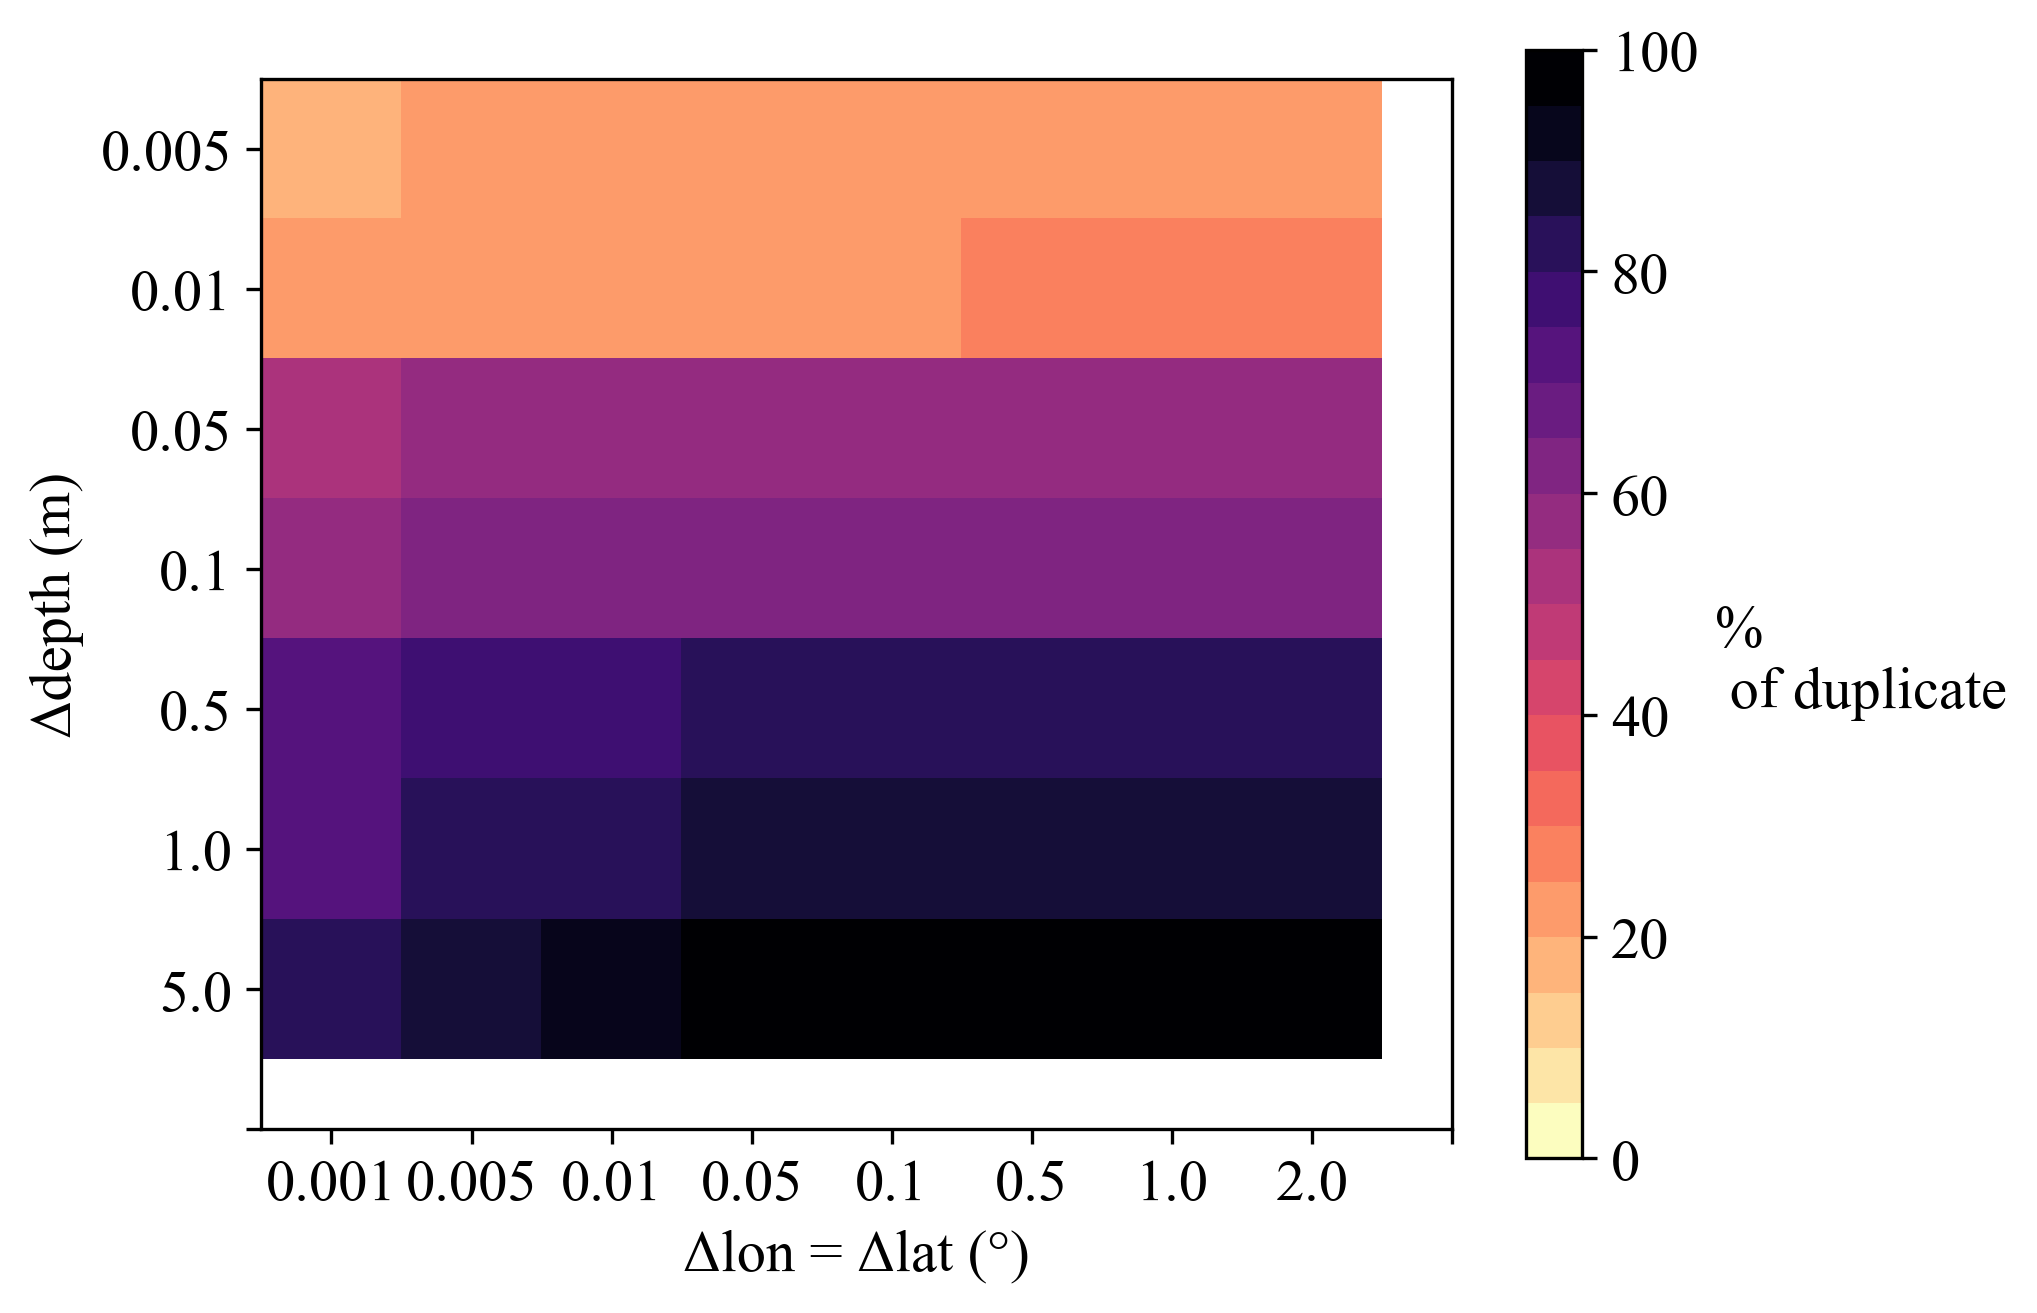

In [21]:
cmap = PyPlot.cm.get_cmap("magma_r", 20)
ax = subplot(111)
pc = imshow(permutedims(duplicate_percent, [2,1]), cmap=cmap, vmin=0, vmax=100)
ax.set_xticks(0:length(Δlon))
ax.set_yticks(0:length(Δdepth))
ax.set_xticklabels(Δlon)
ax.set_yticklabels(Δdepth)
xlabel("Δlon = Δlat (°)")
ylabel("Δdepth (m)")
cb = colorbar(pc)
cb.set_label("%\n of duplicate", rotation=0, ha="left")
PyPlot.savefig("./figures/duplicate_sensitivity.png", dpi=300, bbox_inches="tight")

### Comments
* For large values (>= 0.5°) of the horizontal length, the percentage of duplicates is only 0.01%, while we would expect more duplicates when we increase the *searching radius*.
* For large values of the vertical length (>= 0.05), the horizontal length has not a large influence, i.e., we don't detect more possible duplicates.
* When doing from Δz=0.05 m to Δz=0.01 m, the percentage of duplicates changes abruptly, going from about 25% to more than 55%. 

Now let's check what happens with large horizontal length

In [14]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (obslon1,obslat1,obsdepth1,obstime1), obsval1,
            (obslon2,obslat2,obsdepth2,obstime2), obsval2,
            (1.0, 0.5, 0.01, 1/(24.)), 0.01);

            index = findall(.!isempty.(dupl));
            ndupl = length(index);
            pcdupl = ndupl / ndata1 * 100;
@show pcdupl;
index

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debu

┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Qu

┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debu

┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtr

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debu

┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtree

┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtr

┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ D

┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src

┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug

┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtr

┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src

┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debu

┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debu

┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src

┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug

┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src

┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debu

┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtr

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debu

┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debu

┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debu

┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug

┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src

┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src

┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtree

┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debu

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 0.0, 23263.4] - [3.5, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:3

┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 0.0, 23263.4] - [4.0, 56.9998, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debu

┌ Debug: within_buffer [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 0.0, 23263.4] - [4.0, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 0.0, 23263.4] - [3.5, 56.5, 37.6465, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.j

┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtr

┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src

┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 0.0, 3823.0] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: within_buffer [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.5, 37.6465, 23263.4] - [4.0, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtree

Excessive output truncated after 524448 bytes.┌ Debug: within_buffer [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.5, 37.6465, 23263.4] - [3.5, 56.9998, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.5, 56.0002, 37.6465, 23263.4] - [4.0, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [3.0, 56.0002, 37.6465, 23263.4] - [3.5, 56.5, 75.293, 42703.9]
└ @ DIVAnd.Quadtrees /home/ct

4564-element Array{Int64,1}:
  1269
  1280
  1291
  1292
  1312
  1313
  1324
  1325
  1335
  1336
  1346
  1347
  1357
     ⋮
 30411
 30412
 30413
 30414
 30415
 30416
 30417
 30418
 30419
 30420
 30556
 30557

Only 0.01% of duplicates found...           
Let's plot in an even smaller area.

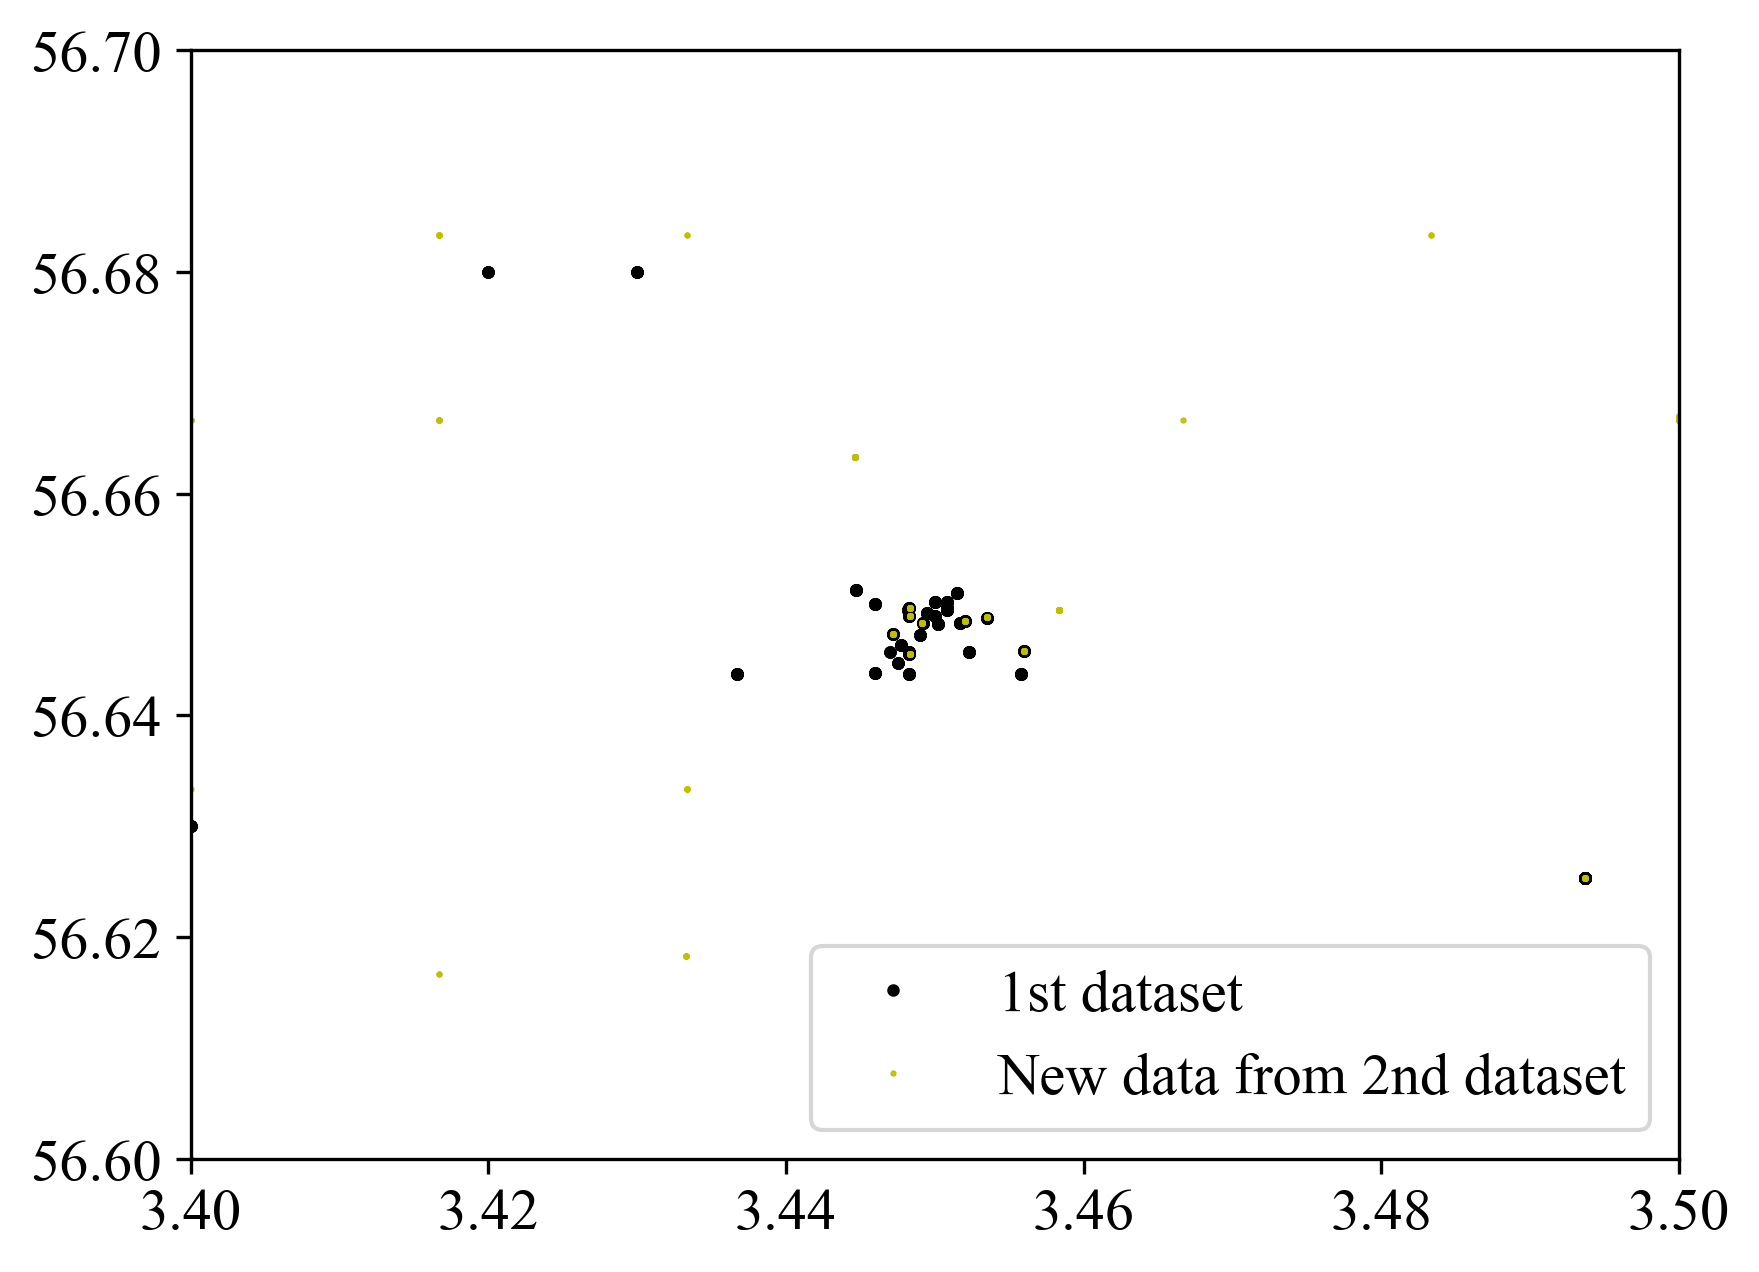

(56.6, 56.7)

In [15]:
newpoints = isempty.(dupl);
PyPlot.plot(obslon1, obslat1, "ko", markersize=2, label="1st dataset")
PyPlot.plot(obslon2[newpoints], obslat2[newpoints], "y.", 
    markersize=1, label="New data from 2nd dataset")
PyPlot.legend()
xlim(3.4, 3.5)
ylim(56.6, 56.7)

It seems some of the *new* observations from the 2nd dataset are at the same position, maybe because the depth or the depth, time or value differ. Too many variables at the same time to understand what is going on.

## Artificial case
We create 2 synthetic 2D dataset using random positions and values.

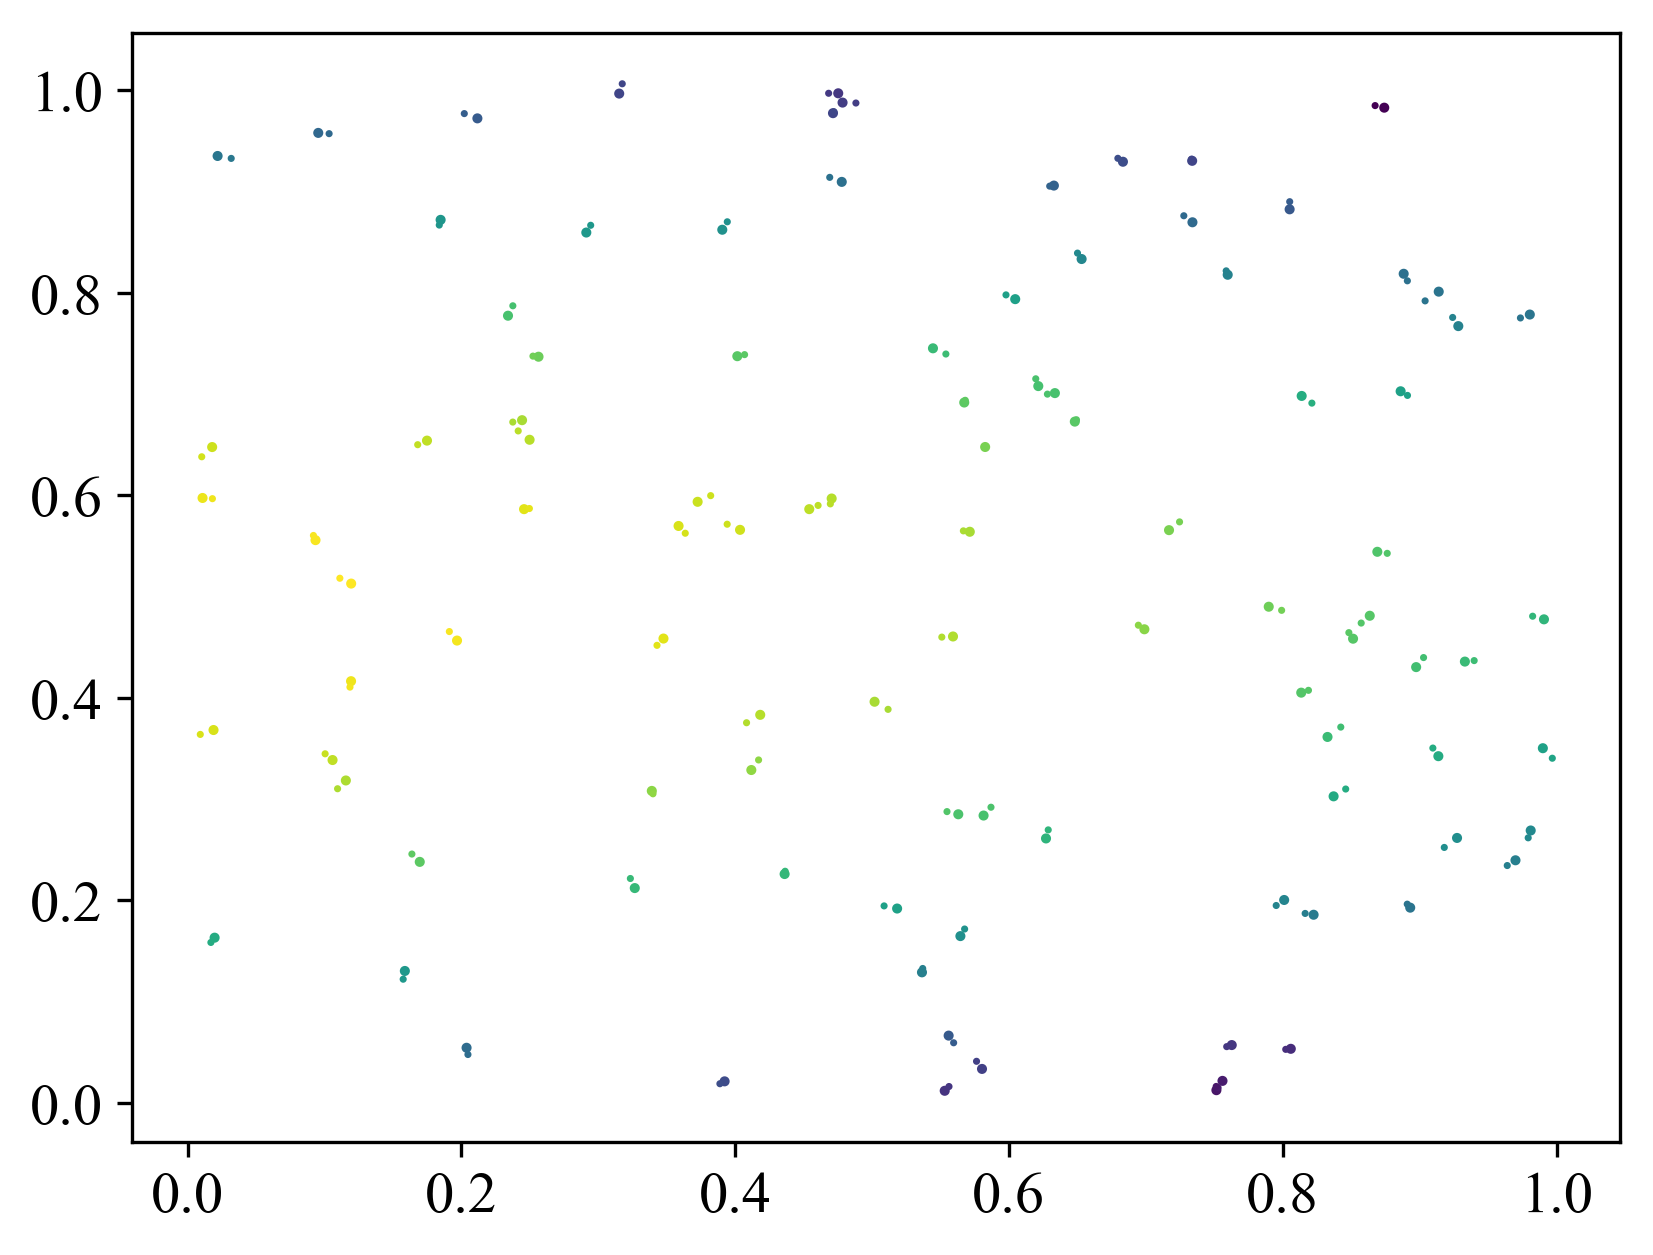

PyObject <matplotlib.collections.PathCollection object at 0x7fc1b68c4c18>

In [7]:
NN = 100;
err = 0.02
Random.seed!(642);
x1 = rand(NN);
Random.seed!(891);
y1 = rand(NN);
z1 = cos.(x1) + sin.(π * y1);
x2 = x1 .+ err * (rand(NN) .- 0.5)
y2 = y1 .+ err * (rand(NN) .- 0.5)
z2 = z1 .+ err * (rand(NN) .- 0.5)
PyPlot.scatter(x1, y1, c=z1, s=2)
PyPlot.scatter(x2, y2, c=z2, s=.5)

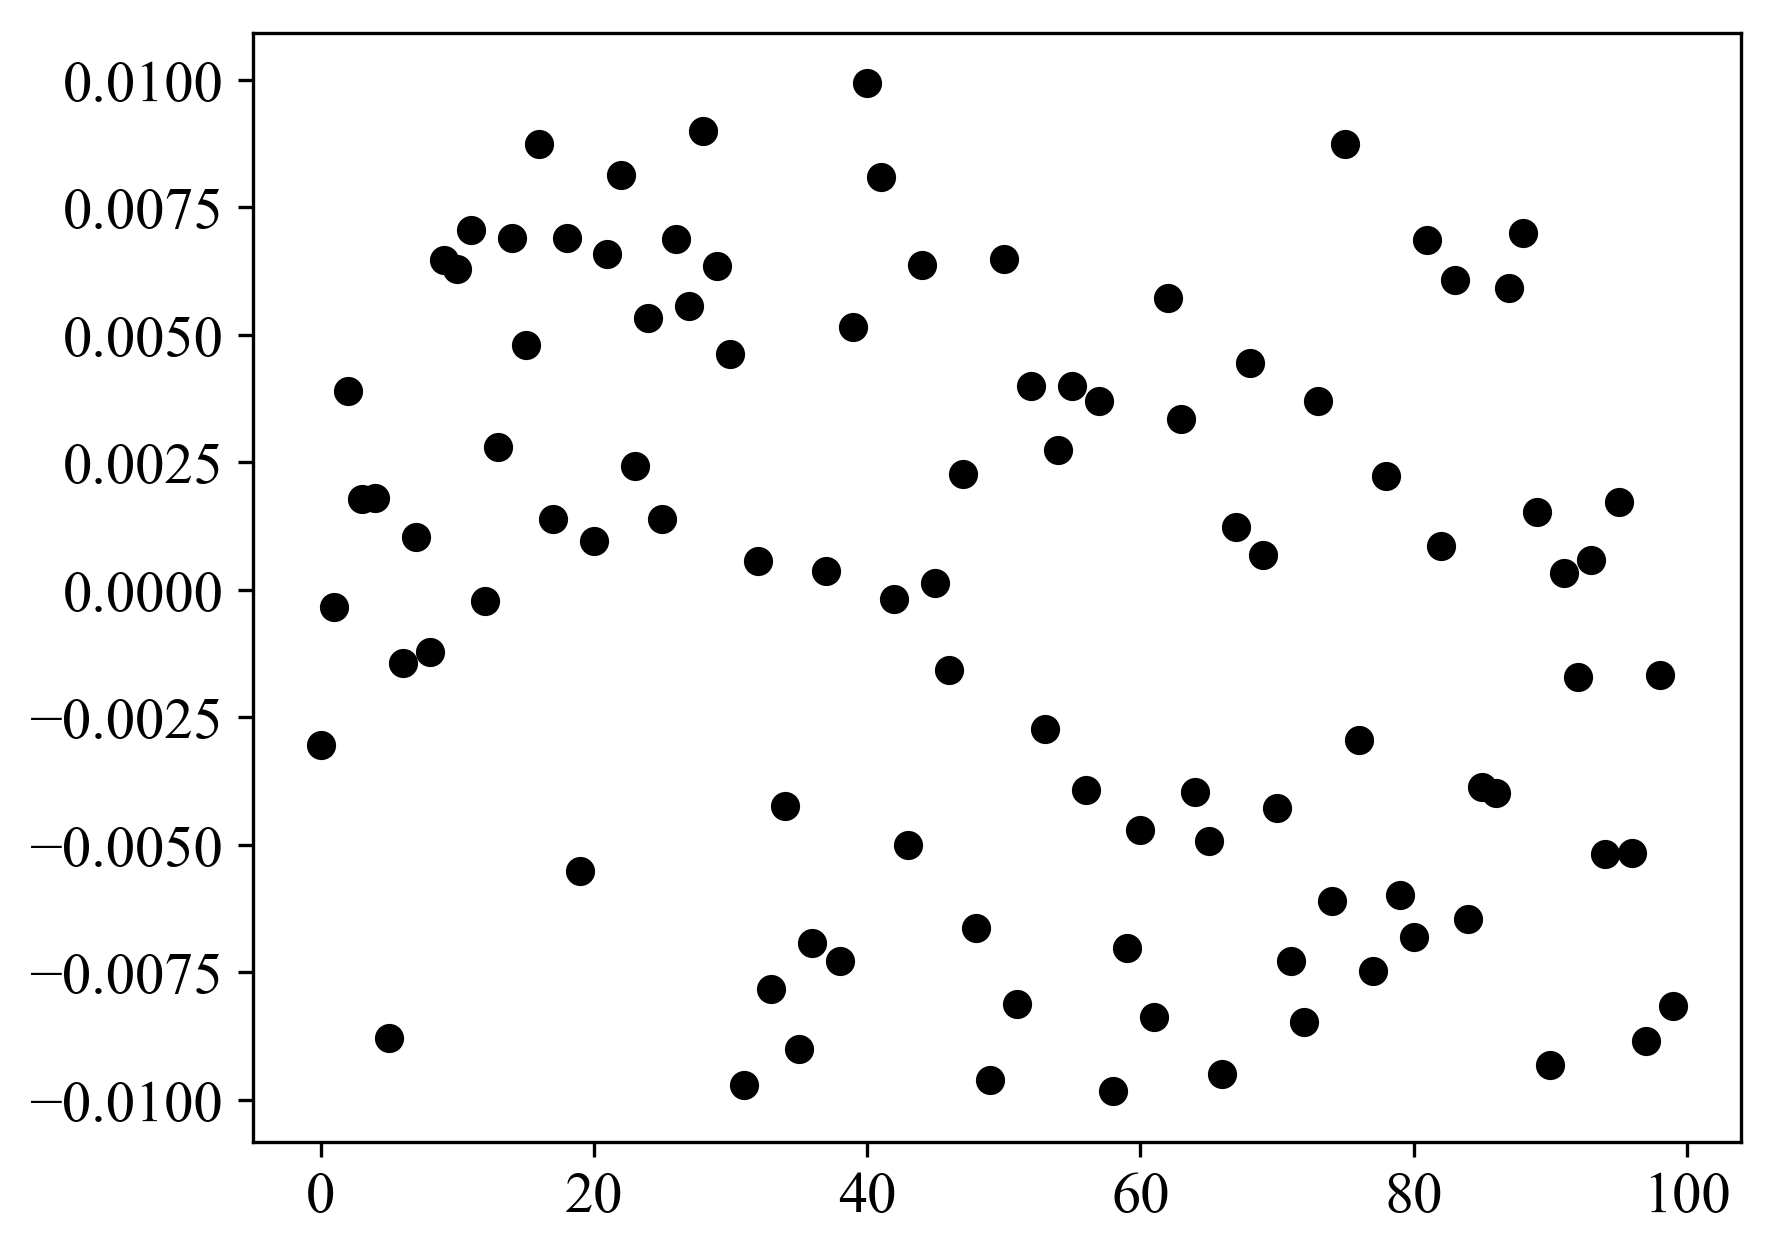

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc19969afd0>

In [9]:
PyPlot.plot(z1 .- z2, "ko")

### Duplicate detection with a large L

In [17]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z1,
            (err * 2, err * 2), 0.01);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100;
@show pcdupl;

┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

  0.453228 seconds (886.25 k allocations: 42.837 MiB, 2.94% gc time)
pcdupl = 100.0


┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

### Duplicate detection with a small L

In [18]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z1,
            (err * 0.01, err * 0.01), 0.01);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100;
@show pcdupl;

┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

  0.011416 seconds (13.24 k allocations: 756.891 KiB)


┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

pcdupl = 3.0


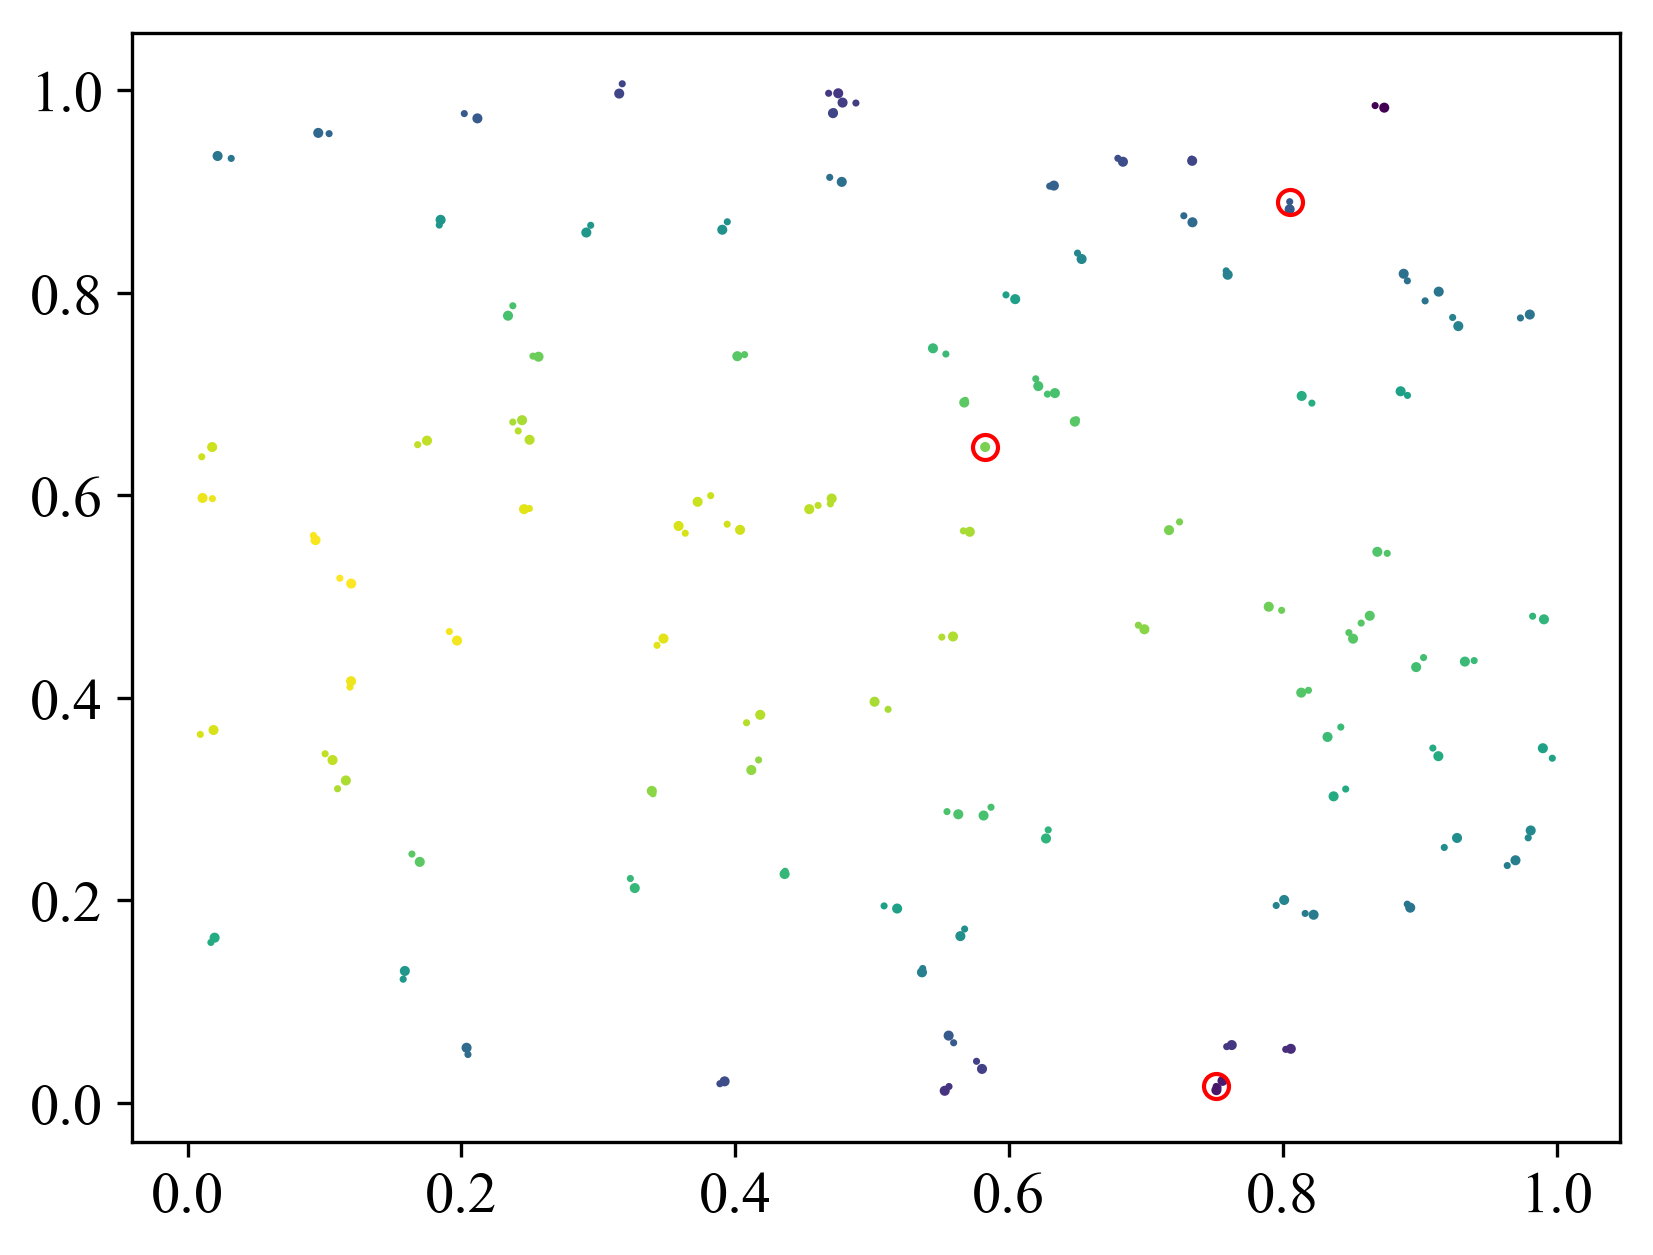

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f33e07897f0>

In [19]:
PyPlot.scatter(x1, y1, c=z1, s=2)
PyPlot.scatter(x2, y2, c=z1, s=.5)
PyPlot.plot(x2[index], y2[index], "ro", markersize=6, markerfacecolor="None")

### Very big values of L
We get (as expected) 100% of duplicates.

In [20]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z1,
            (err * 10000., err * 10000.), 0.01);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100
@show pcdupl;

┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

  0.041884 seconds (14.31 k allocations: 1.269 MiB)
pcdupl = 100.0


┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:378
┌ Debug: leaf [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/ctroupin/.julia/packages/DIVAnd/ZesgF/src/Quadtrees.jl:381
┌ Debug: within_buffer [0.0109463, 0.0119729] - [0.990844, 0.996962]
└ @ DIVAnd.Quadtrees /home/c

### Effect of the observation tolerance
We fix the distance between the observations in the 2 sets (0.25) and add some noise to the field. 

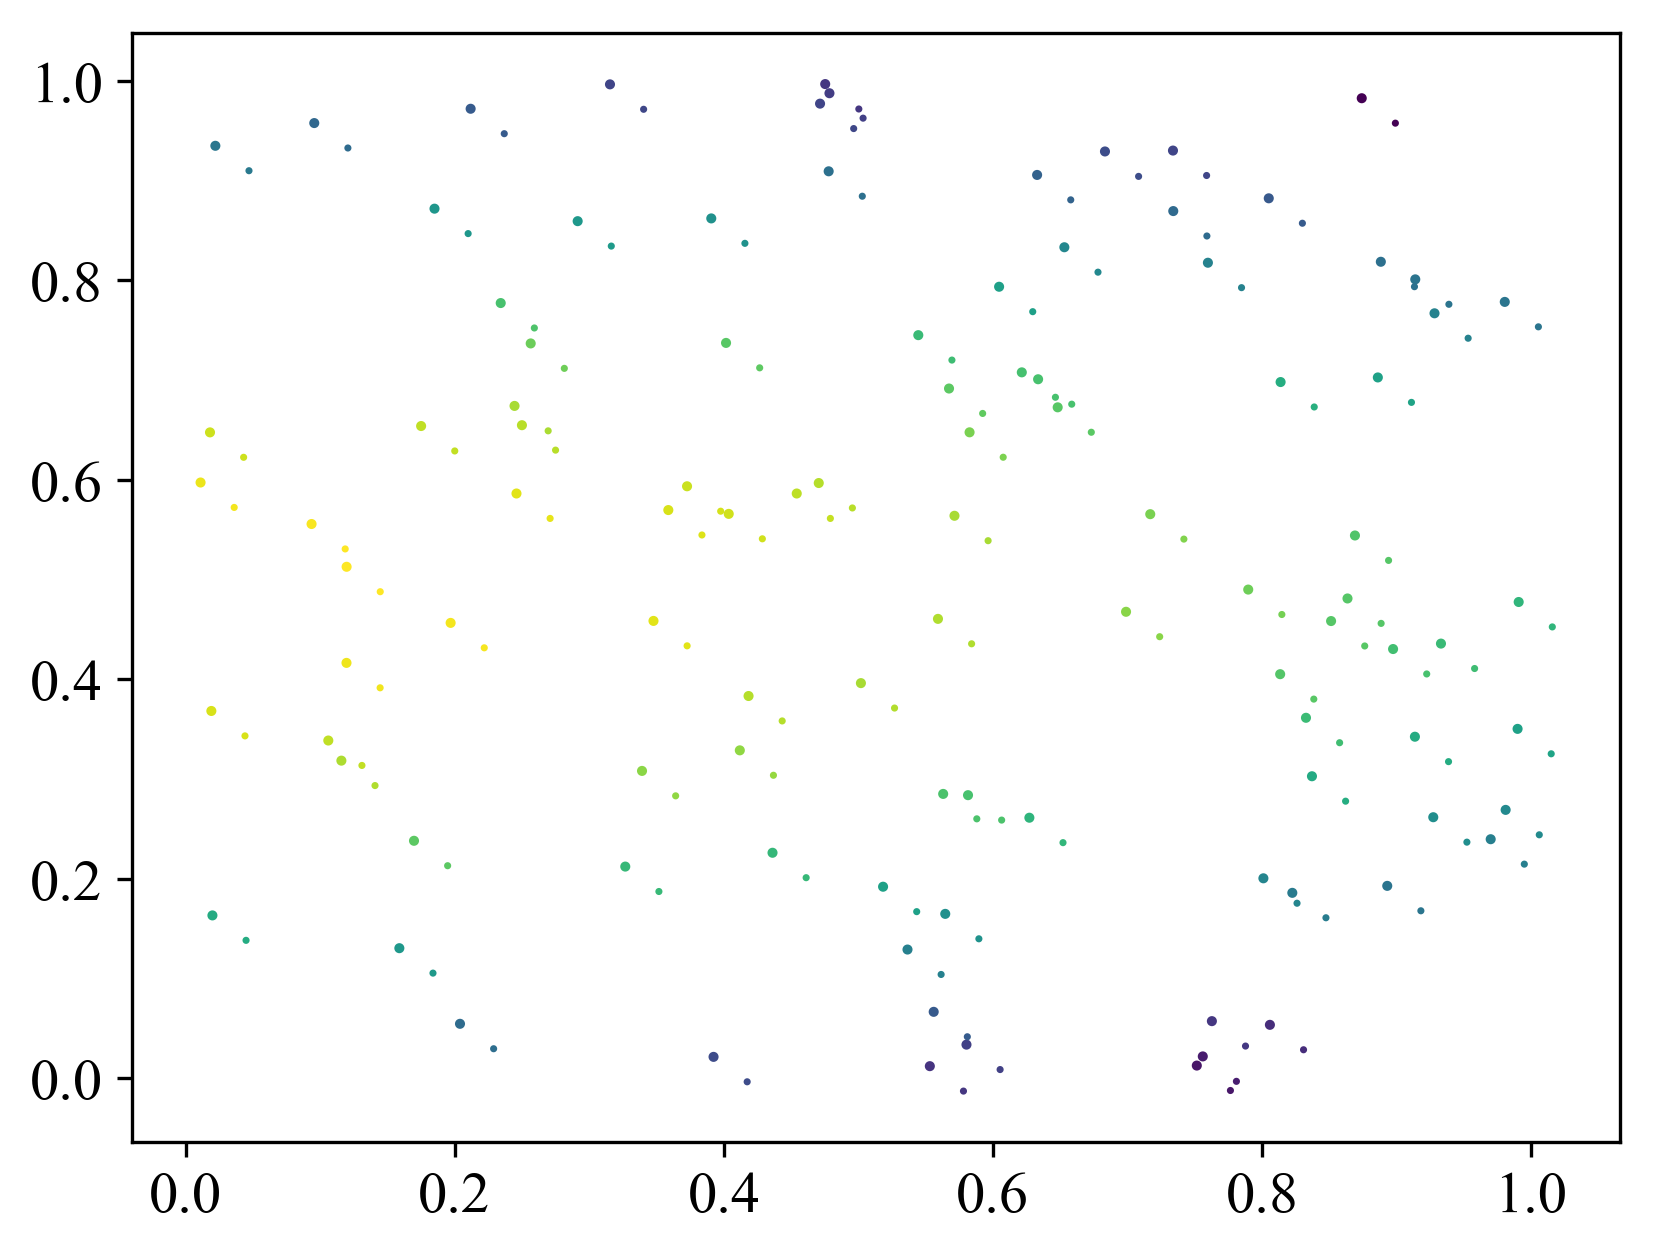

PyObject <matplotlib.collections.PathCollection object at 0x7fc199550588>

In [28]:
Δd = 0.025
NN = 100;
err = 0.02
Random.seed!(642);
x1 = rand(NN);
Random.seed!(891);
y1 = rand(NN);
z1 = cos.(x1) + sin.(π * y1);
x2 = x1 .+ Δd
y2 = y1 .- Δd
z2 = z1 .+ err * (rand(NN) .- 0.5)
PyPlot.scatter(x1, y1, c=z1, s=2)
PyPlot.scatter(x2, y2, c=z2, s=.5)

If we take a spatial tolerance above Δd we should find (almost) 100% of duplicates. 

In [39]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z2,
            (Δd * 2.0, Δd * 2.0), 0.1);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100;
@show pcdupl;

  0.001190 seconds (868 allocations: 476.609 KiB)
pcdupl = 100.0


And the oppositve with a spatial tolerance below Δd.

In [40]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z2,
            (Δd * 0.15, Δd * 0.15), 0.1);

index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = ndupl / NN * 100;
@show pcdupl;

  0.001120 seconds (168 allocations: 16.188 KiB)
pcdupl = 0.0


If we take a value around Δd, it now depends on the value of the tolerance on the observations.

In [47]:
Δval = [0.001, 0.01, 0.1, 1.0, 10.]
for tol in Δval
    @time dupl = DIVAnd.Quadtrees.checkduplicates(
            (x1, y1), z1,
            (x2, y1), z2,
            (Δd * 1., Δd * 1.), tol);

    index = findall(.!isempty.(dupl));
    ndupl = length(index);
    pcdupl = ndupl / NN * 100;
    @show pcdupl;
end

  0.000304 seconds (843 allocations: 459.031 KiB)
pcdupl = 13.0
  0.000280 seconds (843 allocations: 461.625 KiB)
pcdupl = 96.0
  0.000226 seconds (843 allocations: 461.719 KiB)
pcdupl = 97.0
  0.000209 seconds (843 allocations: 461.719 KiB)
pcdupl = 97.0
  0.000199 seconds (843 allocations: 461.719 KiB)
pcdupl = 97.0


In [58]:
?DIVAnd.Quadtrees.checkduplicates

```
dupl = checkduplicates(x,value,delta,deltavalue)
```

Based the coordinates `x` (a tuple of longitude `lons`, latitudes `lats`, depth (`zs`) and time (`times` vector of `DateTime`)) check of points who are in the same spatio-temporal bounding  box of a length `delta`. `delta` is a vector with 4 elements corresponding to longitude, latitude, depth and time (in days). `dupl` a vector of vectors containing indices of the duplicates.

---

```
dupl = checkduplicates(x1,value1,x2,v2,value2,delta,deltavalue)
```

Report duplicate of observation in data set (x2,v2) which are also in data set (x1,v1). `x1` and `x2` is a tuple of vectors with the cooridantes and `v1` and `v2` the corresponding values.
